# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages
One of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. 


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></div>

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('co2_mm_mlo.csv')

### Inspect the data, create a DatetimeIndex

In [2]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


We need to combine two integer columns (year and month) into a DatetimeIndex. We can do this by passing a dictionary into <tt>pandas.to_datetime()</tt> with year, month and day values.<br>
For more information visit https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [3]:
# Add a "date" datetime column
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [4]:
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


### Plot the source data

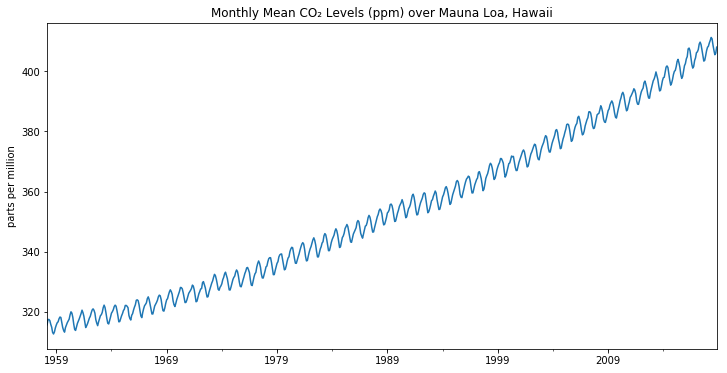

In [5]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Run an ETS Decomposition

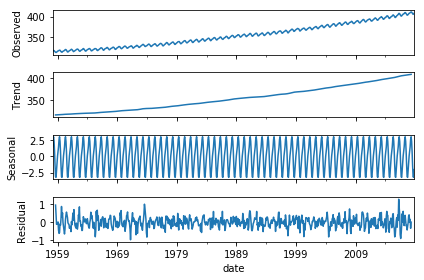

In [6]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

Although small in scale compared to the overall values, there is a definite annual seasonality.

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot more combinations to evaluate.

In [7]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima_fit = auto_arima(df['interpolated'],
                            seasonal=True,m=12,
                            trace=True,
                            error_action='ignore',   # we don't want to know if an order does not work
                            suppress_warnings=True,  # we don't want convergence warnings
                            stepwise= True)

auto_arima_fit.summary()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=459.229, BIC=495.951, Fit time=3.123 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=2369.532, BIC=2378.713, Fit time=0.018 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=804.406, BIC=822.768, Fit time=0.800 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=1614.808, BIC=1633.170, Fit time=0.680 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=1101.965, BIC=1134.097, Fit time=2.836 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 12); AIC=489.312, BIC=530.625, Fit time=10.673 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 12); AIC=766.430, BIC=798.562, Fit time=3.567 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=539.995, BIC=581.308, Fit time=9.228 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=1440.918, BIC=1468.460, Fit time=0.490 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(2, 0, 2, 12)   Log Likelihood                -208.327
Date:                            Sun, 13 Oct 2019   AIC                            430.655
Time:                                    14:48:48   BIC                            462.787
Sample:                                         0   HQIC                           443.053
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.659e-05      0.000      0.337      0.736      -0.000       0.001
ma.L1         -0.3735      0.030    -12.289      0.000      -0.433      -0.314
ar.S.L12       0.0314      0.041      0.762      0.446      -0.049       0.112
ar.S.L24       0.9680      0.041     23.614      0.000       0.888       1.048
ma.S.L12       0.1275      0.111      1.144      0.252      -0.091       0.346
ma.S.L24      -0.8651      0.089     -9.711      0.000      -1.040      -0.690
sigma2         0.0952      0.008     11.555      0.000       0.079       0.111
===================================================================================
Ljung-Box (Q):                       50.37   Jarque-Bera (JB):                 4.24
Prob(Q):                              0.13   Prob(JB):                         0.12
Heteroskedasticity (H):               1.12   Skew:                            -0.04
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (0,1,1) combined with a seasonal order of (2,0,2,12) Now let's train & test the SARIMA(0,1,1)(2,0,2,12) model, evaluate it, then produce a forecast of future values.
*Based on CPU power, the ARIMA and Seasonal order could be different*
### Split the data into train/test sets

In [8]:
len(df)

729

In [9]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

### Fit a SARIMA(0,1,1)(2,0,2,12) Model

In [10]:
model = SARIMAX(train['interpolated'],order=(0,1,1),seasonal_order=(2,0,2,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(2, 0, 2, 12)   Log Likelihood                -205.142
Date:                            Sun, 13 Oct 2019   AIC                            422.285
Time:                                    14:48:53   BIC                            449.727
Sample:                                03-01-1958   HQIC                           432.882
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3707      0.034    -10.756      0.000      -0.438      -0.303
ar.S.L12       0.8742      0.104      8.380      0.000       0.670       1.079
ar.S.L24       0.1254      0.104      1.204      0.229      -0.079       0.330
ma.S.L12      -0.7357      0.103     -7.162      0.000      -0.937      -0.534
ma.S.L24      -0.1128      0.087     -1.294      0.196      -0.284       0.058
sigma2         0.0960      0.005     20.143      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       51.89   Jarque-Bera (JB):                 3.76
Prob(Q):                              0.10   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)(2,0,2,12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [12]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.5809597, expected=406.81
predicted=407.7861948, expected=407.96
predicted=408.528808 , expected=408.32
predicted=409.4334287, expected=409.41
predicted=410.9914828, expected=410.24
predicted=411.5952633, expected=411.24
predicted=410.8149168, expected=410.79
predicted=409.1244936, expected=408.71
predicted=407.0242592, expected=406.99
predicted=405.5718694, expected=405.51
predicted=405.842239 , expected=406.0
predicted=407.3758307, expected=408.02


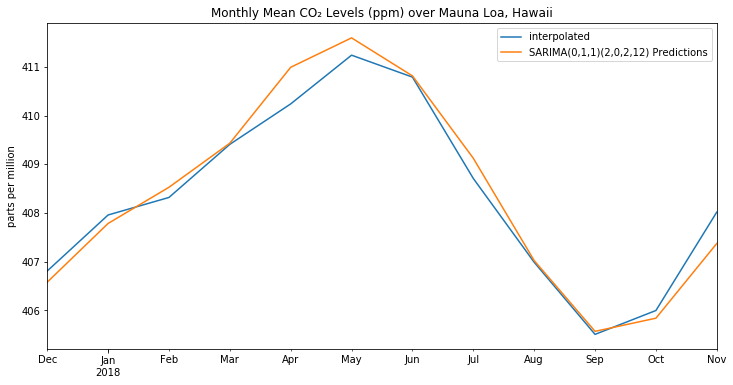

In [13]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [14]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,1)(2,0,2,12) MSE Error: {error:11.10}')

SARIMA(0,1,1)(2,0,2,12) MSE Error: 0.1195854773


In [15]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,1)(2,0,2,12) RMSE Error: {error:11.10}')

SARIMA(0,1,1)(2,0,2,12) RMSE Error: 0.3458113319


These are outstanding results!
### Retrain the model on the full data, and forecast the future

In [16]:
model = SARIMAX(df['interpolated'],order=(0,1,1),seasonal_order=(2,0,2,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,1)(2,0,2,12) Forecast')

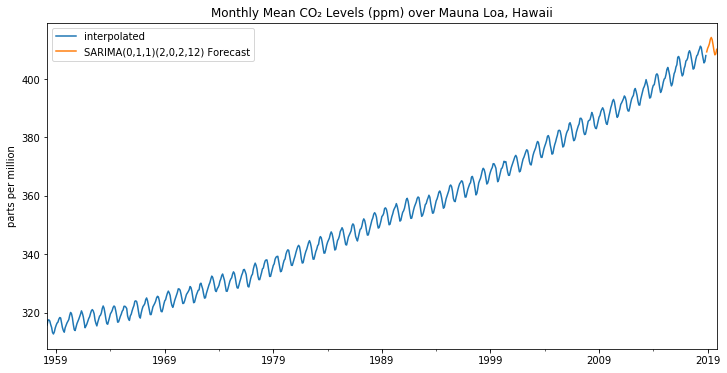

In [17]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);